<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/Sesion%205/4_MLPvsRNN_Ejercicio_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---

#<strong><center>Series temporales con RNNs y MLP en KERAS: Ejercicio</center></strong>

En este ejercicio se propone realizar un estudio similar al del anterior notebook. En este caso se va a emplear un dataset de datos reales 

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

Importamos el fichero de repositorio

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2021-02-05 19:36:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0s      

2021-02-05 19:36:06 (151 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



Lo cargamos y ploteamos para ver su aspecto y comprobar que todo ha ido bien:

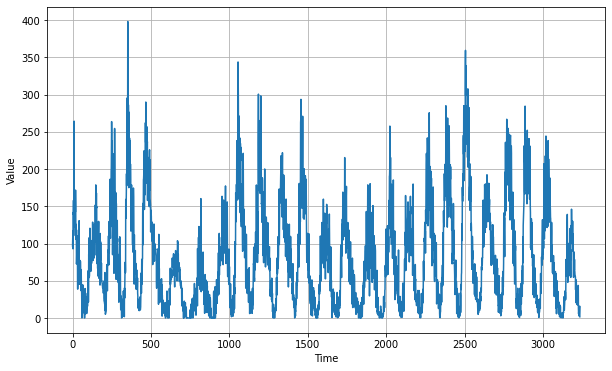

In [3]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

##Inicio del ejercicio

Preparación de parámetros
Configura los parámetros segun estas directrices iniciales:  
* conjunto de entrenamiento sea de 3000 muestras y el resto de validación
* Enventanado de 60 muestras
* Tamaño de lote de 128
* Tamaño de mezcla de buffer de 1000


In [8]:
# Tu código aquí: 
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = time[split_time:]

window_size = 60
batch_size = 128
shuffle_buffer_size = 1000


La función que prepara el dataset a partir del enventanado y parámetros especificados se mantiene igual

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Modelo con RNN

Crea el dataset empleando la función anterior `windowed_dataset`: 


In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Tu código aquí: 
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


Define el modelo de RNN simple con 2 capas de 40 y 40 neuronas respectivamente y la misma arquitectura del ejercicio anterior

In [12]:
# Tu código aquí: 
model = tf.keras.models.Sequential([
tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

Comprueba su arquitectura y cantidad de parámetros

In [13]:
# Tu código aquí: 

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 40)          1680      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dense (Dense)                (None, 1)                 41        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


Antes de su entrenamiento definitivo, realiza una exploración sobre el conjunto de entrenamiento para determinar un learning rate óptimo

In [15]:
# Tu código aquí: 

train_set = dataset

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)) ###CÓMO FUNCIONA ESTA FUNCIÓN????

optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
23/23 [==============================] - 4s 78ms/step - loss: 142.6576 - mae: 143.1573
Epoch 2/100
23/23 [==============================] - 2s 77ms/step - loss: 137.7770 - mae: 138.2761
Epoch 3/100
23/23 [==============================] - 2s 77ms/step - loss: 129.5360 - mae: 130.0350
Epoch 4/100
23/23 [==============================] - 2s 80ms/step - loss: 121.5594 - mae: 122.0587
Epoch 5/100
23/23 [==============================] - 2s 80ms/step - loss: 116.4168 - mae: 116.9163
Epoch 6/100
23/23 [==============================] - 2s 81ms/step - loss: 108.1795 - mae: 108.6793
Epoch 7/100
23/23 [==============================] - 2s 79ms/step - loss: 101.2684 - mae: 101.7679
Epoch 8/100
23/23 [==============================] - 2s 79ms/step - loss: 94.2924 - mae: 94.7913
Epoch 9/100
23/23 [==============================] - 2s 79ms/step - loss: 90.0240 - mae: 90.5235
Epoch 10/100
23/23 [==============================] - 2s 78ms/step - loss: 82.7527 - mae: 83.2512
Epoch 11/100
23

Visualiza el error para elegir el mejor lr

(1e-08, 0.0001, 0.0, 30.0)

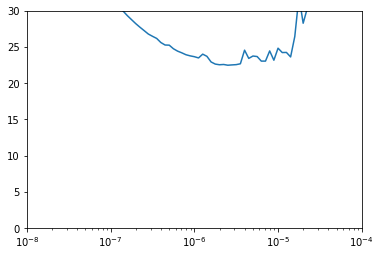

In [16]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

Configura ahora y reentrena con la tasa de lr elegida, tal como hemos hecho en el ejercicio anterior y 200 epochs

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# Tu código aquí: 
dataset = dataset

model = model

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset, epochs=100)


Epoch 1/100
23/23 [==============================] - 3s 81ms/step - loss: 20.6603 - mae: 21.1543
Epoch 2/100
23/23 [==============================] - 2s 77ms/step - loss: 21.3808 - mae: 21.8745
Epoch 3/100
23/23 [==============================] - 2s 81ms/step - loss: 20.9758 - mae: 21.4670
Epoch 4/100
23/23 [==============================] - 2s 80ms/step - loss: 21.3340 - mae: 21.8266
Epoch 5/100
23/23 [==============================] - 2s 80ms/step - loss: 20.9346 - mae: 21.4267
Epoch 6/100
23/23 [==============================] - 2s 82ms/step - loss: 21.5975 - mae: 22.0908
Epoch 7/100
23/23 [==============================] - 2s 80ms/step - loss: 21.0091 - mae: 21.5028
Epoch 8/100
23/23 [==============================] - 2s 79ms/step - loss: 20.8964 - mae: 21.3892
Epoch 9/100
23/23 [==============================] - 2s 80ms/step - loss: 21.4224 - mae: 21.9152
Epoch 10/100
23/23 [==============================] - 2s 84ms/step - loss: 21.1095 - mae: 21.6012
Epoch 11/100
23/23 [=========

Realizamos predicciones y visualizamos resultados igual que en ejemplo anterior

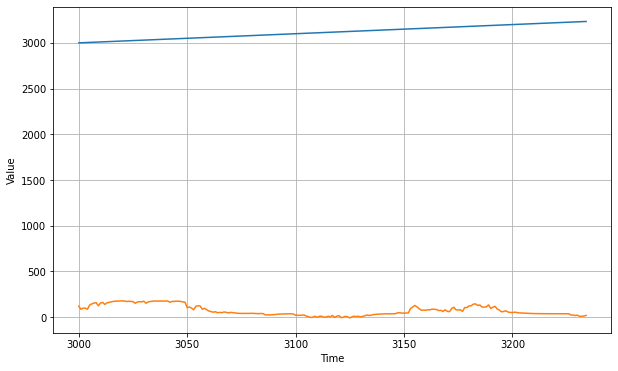

In [19]:
forecast=[]

# Tu código aquí: 

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

Obtenemos una métrica de error numérica para poder realizar comparaciones: 

In [ ]:
# Tu código aquí: 


Visualiza el error y la métrica de salida MAE para ver su relación. Los valores los tenemos en la lista history[ ]

## Modelo con MLP (*MultiLayer Perceptron*)

Vamos ahora a plantear un modelo equivalente con la red neuronal multicapa. 

Implementa el mismo numero de capas (2) y neuronas por (20 y 10) capa con función de activación "relu"

In [ ]:
# Tu código aquí: 
model2 = 


Comprueba arquitectura y parámetros

In [ ]:
# Tu código aquí: 


Mismos parámetros de compilacion, pérdida y optimizador

In [ ]:
model2.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))

Entrena durante el mismo número de epochs (200)

In [ ]:
# Tu código aquí: 



Prediccion y visualización de resultados

In [ ]:
forecast = []

# Tu código aquí: 



Métrica de resultados

In [ ]:
# Tu código aquí: 



Enhorabuena, has llegado al final del ejercicio!

Ahora reflexiona sobre los resultados obtenidos: 
* ¿Cual ha funcionado mejor? 
* ¿Porqué crees que es?

Repite el entrenamiento variando diferentes parámetros y observa como influyen en los resultados y los tiempos: 
* tamaño del lote
* arquitectura de la red - nº de neuronas
* tasa de aprendizaje
* nº de epochs
* enventanado

##Referencias


*   Documento inspirado en los ejemplos del repositorio de LaurenceMorone y en su curso de Deep Learning con TensorFlow: https://github.com/lmoroney?tab=repositories 
* Doc oficial Pytorch https://pytorch.org/docs/stable/generated/torch.nn.RNN.html
* https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html


##Fin del cuaderno